In [1]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/Task 1 Food Segmentation Dataset.zip'
extracted_dir = '/content/drive/MyDrive/Food Segmentation'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Dataset extracted to {extracted_dir}")


In [91]:
img_dir_train = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/Images/img_dir/train'
ann_dir_train = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/Images/ann_dir/train'
train_txt_path = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/ImageSets/train.txt'
img_dir_test = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/Images/img_dir/test'
ann_dir_test = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/Images/ann_dir/test'
test_txt_path = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/ImageSets/test.txt'
category_file = '/content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/category_id.txt'


In [92]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import jaccard_score
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast  # Updated for new API

Successfully loaded mask: /content/drive/MyDrive/Food Segmentation/Task 1 Food Segmentation Dataset/FoodSeg103/Images/ann_dir/train/00003651.png
Mask shape: (1920, 2560), dtype: uint8, unique values: [ 0 28 48 52]


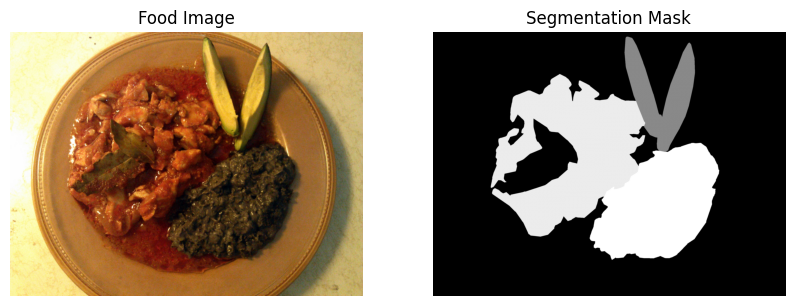

In [94]:


# List all image files
image_files = sorted(os.listdir(img_dir_train))
random_image = random.choice(image_files)  # Pick a random image name

# Load the corresponding mask
mask_filename = os.path.splitext(random_image)[0] + ".png"
mask_path = os.path.join(ann_dir_train, mask_filename)
image_path = os.path.join(img_dir_train, random_image)

# Load the image and mask
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if mask is None:
    print(f"Failed to load mask: {mask_path}")
else:
    print(f"Successfully loaded mask: {mask_path}")
    print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}, unique values: {np.unique(mask)}")

    mask = mask.astype(np.uint8)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Food Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Segmentation Mask")
    ax[1].axis("off")

    plt.show()


In [95]:


# Custom Dataset Class
class CustomFoodSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, annotations_file, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = []

        try:
            with open(annotations_file, "r") as file:
                self.images = [line.strip() for line in file if line.strip()]
        except FileNotFoundError:
            raise FileNotFoundError(f"Annotations file {annotations_file} not found.")

        self.masks = [f.replace(".jpg", ".png") for f in self.images]

        # Pre-filter and cache file existence
        self.valid_pairs = [(img, mask) for img, mask in zip(self.images, self.masks)
                           if os.path.exists(os.path.join(image_dir, img)) and os.path.exists(os.path.join(mask_dir, mask))]

        self.images, self.masks = zip(*self.valid_pairs) if self.valid_pairs else ([], [])

        if not self.images:
            raise ValueError("No valid image-mask pairs found.")

        print(f" {len(self.images)} image-mask pairs loaded successfully.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        try:
            # Load and preprocess once
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError(f"Failed to load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Failed to load mask: {mask_path}")

            # Resize
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            mask = np.clip(mask, 0, 102).astype(np.uint8)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image, mask = augmented['image'], augmented['mask']

            return image, mask
        except Exception as e:
            print(f"Error loading data at index {index}: {str(e)}")
            return None, None

# Data Augmentation
augmentation_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=0.1,
        rotate=(-15, 15),
        p=0.5
    ),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})




In [96]:
# Model Definition with resnet 101
class SegmentationModel(nn.Module):
    def __init__(self, num_classes=104):
        super(SegmentationModel, self).__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet101",
            encoder_weights="imagenet",
            in_channels=3,
            classes=num_classes
        )

    def forward(self, x):
        return self.model(x)


In [97]:
# Loss and Metrics Functions
def dice_loss(pred, target, smooth=1e-5):
    pred = torch.softmax(pred, dim=1)
    target = torch.nn.functional.one_hot(target, num_classes=104).permute(0, 3, 1, 2).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    return 1 - ((2. * intersection + smooth) / (union + smooth)).mean()

def calculate_mIoU(model, dataloader, device, max_batches=None):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if images is None or masks is None:
                continue

            if max_batches and i >= max_batches:
                break

            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()

            for j in range(preds.shape[0]):
                score = jaccard_score(masks[j].flatten(), preds[j].flatten(), average="macro", zero_division=0)
                iou_scores.append(score)

    return np.mean(iou_scores) if iou_scores else 0.0

In [98]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = CustomFoodSegDataset(img_dir_train, ann_dir_train, train_txt_path, transform=augmentation_transform)
test_dataset = CustomFoodSegDataset(img_dir_test, ann_dir_test, test_txt_path, transform=augmentation_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

# Model and optimizer
model = SegmentationModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scaler = GradScaler('cuda')

num_epochs = 20
best_miou = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        if images is None or masks is None:
            continue

        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True).long()

        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = dice_loss(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        train_miou = calculate_mIoU(model, train_loader, device, max_batches=5)
        test_miou = calculate_mIoU(model, test_loader, device, max_batches=5)

    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train mIoU: {train_miou:.4f}, Test mIoU: {test_miou:.4f}")

    if test_miou > best_miou:
        best_miou = test_miou
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Model saved with Test mIoU: {best_miou:.4f}")



Using device: cuda
 4983 image-mask pairs loaded successfully.
 2135 image-mask pairs loaded successfully.
Epoch 1/20, Loss: 0.9877, Train mIoU: 0.1562, Test mIoU: 0.1437
Model saved with Test mIoU: 0.1437
Epoch 2/20, Loss: 0.9834, Train mIoU: 0.1531, Test mIoU: 0.1307
Epoch 3/20, Loss: 0.9820, Train mIoU: 0.1811, Test mIoU: 0.1622
Model saved with Test mIoU: 0.1622
Epoch 4/20, Loss: 0.9809, Train mIoU: 0.1674, Test mIoU: 0.1456
Epoch 5/20, Loss: 0.9803, Train mIoU: 0.1883, Test mIoU: 0.1530
Epoch 6/20, Loss: 0.9798, Train mIoU: 0.1453, Test mIoU: 0.1370
Epoch 7/20, Loss: 0.9795, Train mIoU: 0.1479, Test mIoU: 0.1328
Epoch 8/20, Loss: 0.9792, Train mIoU: 0.1516, Test mIoU: 0.1357
Epoch 9/20, Loss: 0.9790, Train mIoU: 0.1566, Test mIoU: 0.1334
Epoch 10/20, Loss: 0.9789, Train mIoU: 0.1830, Test mIoU: 0.1478
Epoch 11/20, Loss: 0.9785, Train mIoU: 0.1579, Test mIoU: 0.1440
Epoch 12/20, Loss: 0.9785, Train mIoU: 0.1855, Test mIoU: 0.1377
Epoch 13/20, Loss: 0.9782, Train mIoU: 0.1517, Test 

In [101]:
model.eval()
with torch.no_grad():
    test_miou = calculate_mIoU(model, test_loader, device, max_batches=5)
print(f"Final Test mIoU: {test_miou:.4f}")


Final Test mIoU: 0.1622


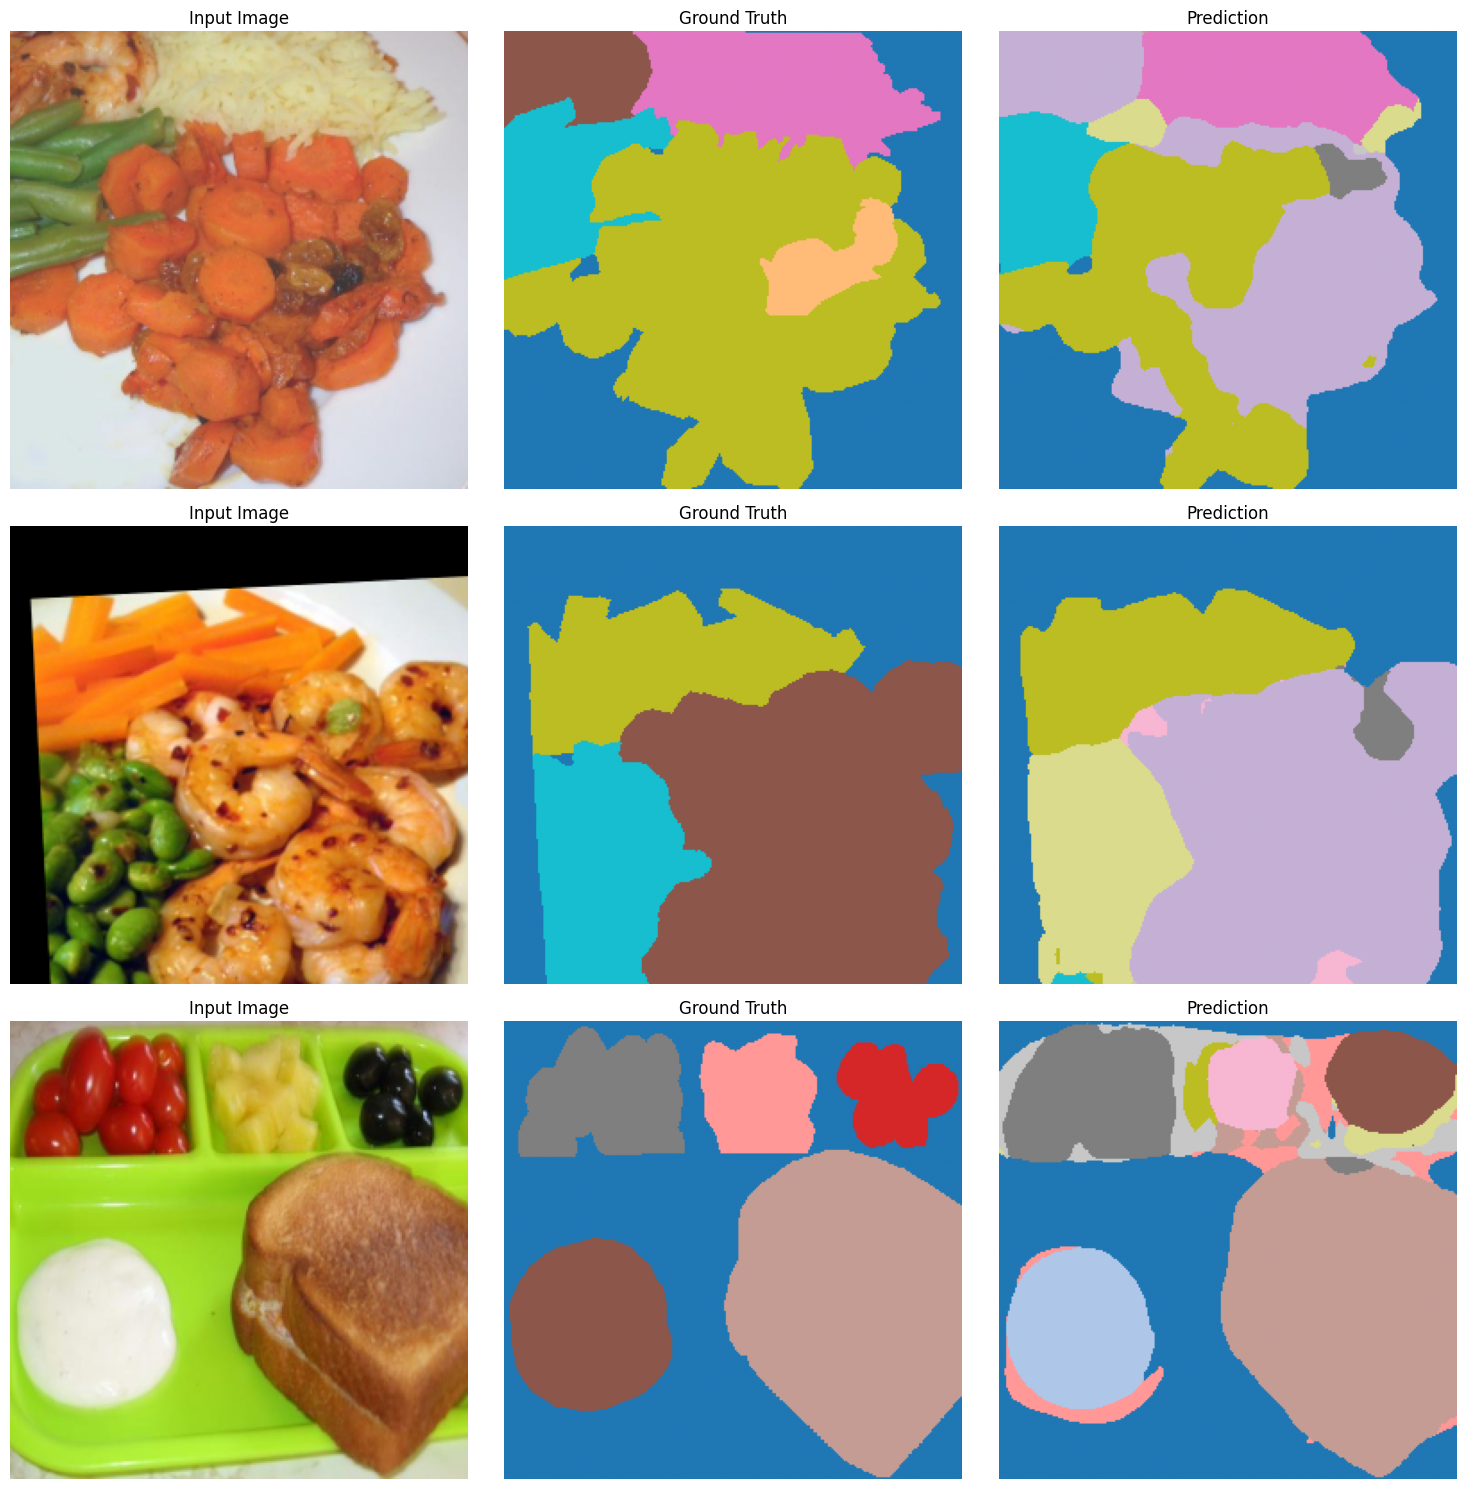

In [102]:
def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    images, masks, preds = [], [], []

    with torch.no_grad():
        for i, (batch_images, batch_masks) in enumerate(dataloader):
            if i >= 1:
                break

            if batch_images is None or batch_masks is None:
                continue

            batch_images, batch_masks = batch_images.to(device, non_blocking=True), batch_masks.to(device, non_blocking=True).long()
            outputs = model(batch_images)
            batch_preds = torch.argmax(outputs, dim=1)

            # Collect samples
            images.extend(batch_images.cpu().numpy().transpose(0, 2, 3, 1)[:num_samples - len(images)])
            masks.extend(batch_masks.cpu().numpy()[:num_samples - len(masks)])
            preds.extend(batch_preds.cpu().numpy()[:num_samples - len(preds)])

            if len(images) >= num_samples:
                break

    cmap = plt.get_cmap('tab20' if num_samples <= 20 else 'jet')

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(images))):
        # Denormalize the image for visualization
        img = images[i] * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization
        img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] for display

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        # Colored mask (ground truth)
        axes[i, 1].imshow(masks[i], cmap=cmap, vmin=0, vmax=103)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        # Colored prediction
        axes[i, 2].imshow(preds[i], cmap=cmap, vmin=0, vmax=103)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_loader, device)

Loss function update and train with validation

In [77]:
import torch
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader, random_split

# Adaptive Combined Loss Function with Dynamic alpha
def combined_loss(pred, target, smooth=1e-5):
    # Apply softmax to the predictions for Dice loss
    pred_softmax = torch.softmax(pred, dim=1)

    # One-hot encode the target
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=104).permute(0, 3, 1, 2).float()

    # Calculate Dice loss
    intersection = (pred_softmax * target_one_hot).sum(dim=(2, 3))
    union = pred_softmax.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)

    # Calculate Cross-Entropy loss
    ce_loss = F.cross_entropy(pred, target)

    # Adaptive weighting between Dice and Cross-Entropy loss
    adaptive_alpha = 1 - (ce_loss / (dice_loss + ce_loss + smooth))

    # Combine both Dice and Cross-Entropy loss
    combined = adaptive_alpha * dice_loss.mean() + (1 - adaptive_alpha) * ce_loss

    return combined.mean()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = CustomFoodSegDataset(img_dir_train, ann_dir_train, train_txt_path, transform=augmentation_transform)
test_dataset = CustomFoodSegDataset(img_dir_test, ann_dir_test, test_txt_path, transform=augmentation_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

# Model and optimizer
model = SegmentationModel().to(device)
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Mixed precision training
scaler = GradScaler()

scheduler = CosineAnnealingLR(optimizer, T_max=50)

num_epochs = 50
best_miou = 0.0

# Training Loop with validation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        if images is None or masks is None:
            continue

        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True).long()

        optimizer.zero_grad()
        with autocast(device_type='cuda'):  # Mixed precision training
            outputs = model(images)
            loss = combined_loss(outputs, masks)

        scaler.scale(loss).backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Validation phase
    model.eval()
    with torch.no_grad():
        train_miou = calculate_mIoU(model, train_loader, device, max_batches=5)
        val_miou = calculate_mIoU(model, val_loader, device, max_batches=5)

    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train mIoU: {train_miou:.4f}, Validation mIoU: {val_miou:.4f}")

    # Save model if validation mIoU improves
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Model saved with Validation mIoU: {best_miou:.4f}")

    # Step the learning rate scheduler
    scheduler.step()


Using device: cuda
 4983 image-mask pairs loaded successfully.
 2135 image-mask pairs loaded successfully.
Epoch 1/50, Loss: 2.1169, Train mIoU: 0.1637, Validation mIoU: 0.2123
Model saved with Validation mIoU: 0.2123
Epoch 2/50, Loss: 1.4348, Train mIoU: 0.2570, Validation mIoU: 0.2787
Model saved with Validation mIoU: 0.2787
Epoch 3/50, Loss: 1.2988, Train mIoU: 0.2771, Validation mIoU: 0.2933
Model saved with Validation mIoU: 0.2933
Epoch 4/50, Loss: 1.2248, Train mIoU: 0.2844, Validation mIoU: 0.3377
Model saved with Validation mIoU: 0.3377
Epoch 5/50, Loss: 1.1697, Train mIoU: 0.3235, Validation mIoU: 0.3473
Model saved with Validation mIoU: 0.3473
Epoch 6/50, Loss: 1.1358, Train mIoU: 0.3050, Validation mIoU: 0.3509
Model saved with Validation mIoU: 0.3509
Epoch 7/50, Loss: 1.1147, Train mIoU: 0.2749, Validation mIoU: 0.3432
Epoch 8/50, Loss: 1.0888, Train mIoU: 0.2980, Validation mIoU: 0.3443
Epoch 9/50, Loss: 1.0660, Train mIoU: 0.3311, Validation mIoU: 0.3690
Model saved with 

In [87]:
model.eval()
with torch.no_grad():
    test_miou = calculate_mIoU(model, test_loader, device, max_batches=5)
print(f"Final Test mIoU: {test_miou:.4f}")


Final Test mIoU: 0.3193


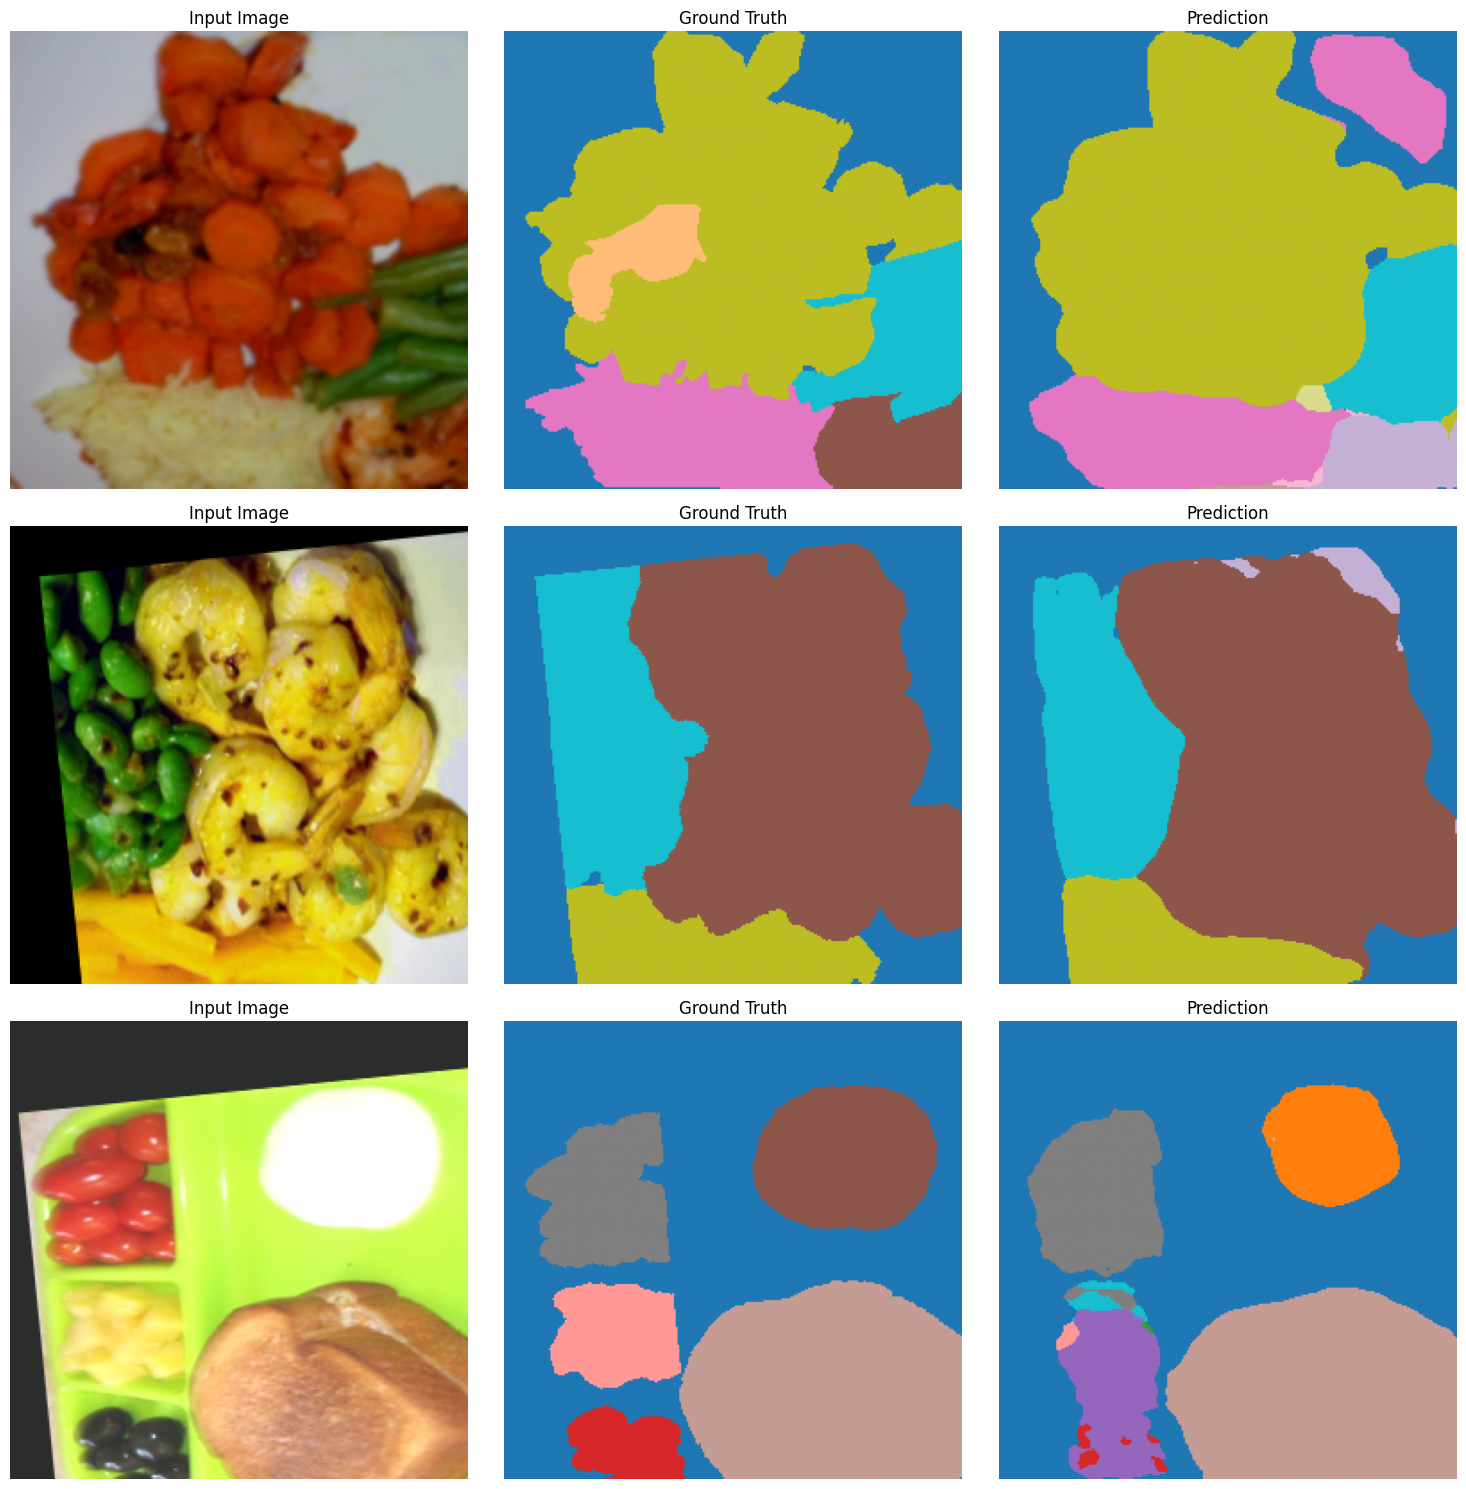

In [88]:
def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    images, masks, preds = [], [], []

    with torch.no_grad():
        for i, (batch_images, batch_masks) in enumerate(dataloader):
            if i >= 1:
                break

            if batch_images is None or batch_masks is None:
                continue

            batch_images, batch_masks = batch_images.to(device, non_blocking=True), batch_masks.to(device, non_blocking=True).long()
            outputs = model(batch_images)
            batch_preds = torch.argmax(outputs, dim=1)

            # Collect samples
            images.extend(batch_images.cpu().numpy().transpose(0, 2, 3, 1)[:num_samples - len(images)])
            masks.extend(batch_masks.cpu().numpy()[:num_samples - len(masks)])
            preds.extend(batch_preds.cpu().numpy()[:num_samples - len(preds)])

            if len(images) >= num_samples:
                break

    cmap = plt.get_cmap('tab20' if num_samples <= 20 else 'jet')

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(images))):
        # Denormalize the image for visualization
        img = images[i] * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization
        img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] for display

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        # Colored mask (ground truth)
        axes[i, 1].imshow(masks[i], cmap=cmap, vmin=0, vmax=103)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        # Colored prediction
        axes[i, 2].imshow(preds[i], cmap=cmap, vmin=0, vmax=103)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_loader, device)

In [89]:
import matplotlib.pyplot as plt

def predict_mask_and_compute_miou(model, image_path, mask_path=None, device='cuda', transform=None):

    model.eval()

    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

    # Load ground truth mask if provided
    gt_mask = None
    if mask_path:
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None:
            raise ValueError(f"Failed to load mask: {mask_path}")
        gt_mask = cv2.resize(gt_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        gt_mask = np.clip(gt_mask, 0, 102).astype(np.uint8)


    if transform:
        if gt_mask is not None:
            augmented = transform(image=image_resized, mask=gt_mask)
            image_transformed, gt_mask = augmented['image'], augmented['mask']
        else:
            augmented = transform(image=image_resized)
            image_transformed = augmented['image']
    else:
        # Default to simple tensor conversion if no transform
        image_transformed = torch.from_numpy(image_resized.transpose(2, 0, 1)).float() / 255.0

    # Prepare image for model
    image_transformed = image_transformed.unsqueeze(0).to(device)  #

    # Generate prediction
    with torch.no_grad():
        with autocast(device_type=device.type):
            output = model(image_transformed)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: 256x256

    # Compute mIoU if ground truth mask is provided
    miou = None
    if gt_mask is not None:
        miou = jaccard_score(gt_mask.flatten(), pred_mask.flatten(), average="macro", zero_division=0)
        print(f"mIoU between predicted and ground truth mask: {miou:.4f}")

    # Visualization
    if mask_path:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image_resized)
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        axes[1].imshow(gt_mask, cmap='jet', vmin=0, vmax=103)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=103)
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.suptitle(f"mIoU: {miou:.4f}" if miou is not None else "Prediction")
        plt.show()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image_resized)
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        axes[1].imshow(pred_mask, cmap='jet', vmin=0, vmax=103)
        axes[1].set_title("Predicted Mask")
        axes[1].axis('off')

        plt.suptitle("Prediction (No Ground Truth Provided)")
        plt.show()

    return pred_mask, miou



mIoU between predicted and ground truth mask: 0.4524


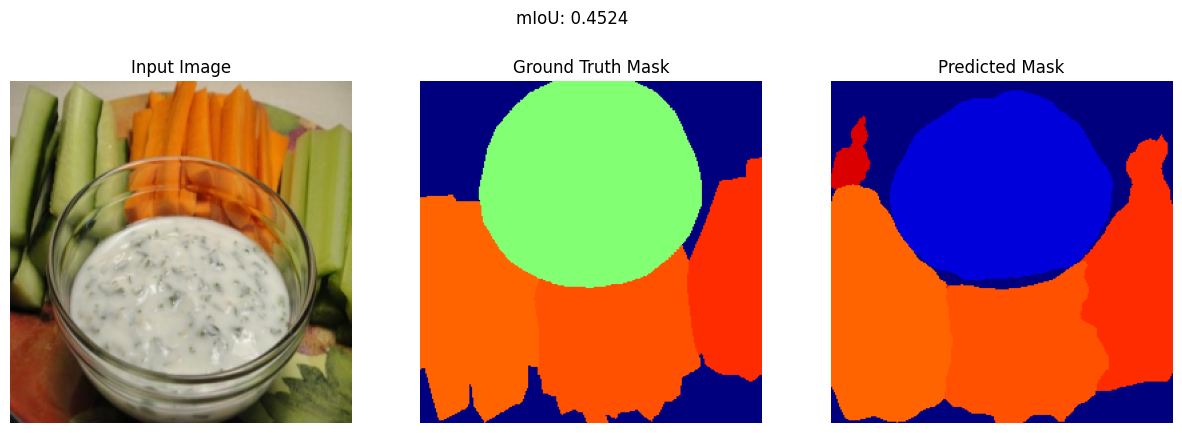

In [90]:
pred_mask, miou = predict_mask_and_compute_miou(model, "/content/drive/MyDrive/00005590.jpg", "/content/drive/MyDrive/00005590gt.png", device, augmentation_transform)